In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Import Library**

In [2]:
import yfinance as yf

import data for google stock from yfinance from 2004 to 2023



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

In [4]:
dataset=yf.download('GOOGL',start='2004-01-16',end='2023-01-16',period='1d')

[*********************100%***********************]  1 of 1 completed


**Data Exploration**


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4634 entries, 2004-08-19 00:00:00-04:00 to 2023-01-13 00:00:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4634 non-null   float64
 1   High       4634 non-null   float64
 2   Low        4634 non-null   float64
 3   Close      4634 non-null   float64
 4   Adj Close  4634 non-null   float64
 5   Volume     4634 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 382.5 KB


In [6]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19 00:00:00-04:00,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20 00:00:00-04:00,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23 00:00:00-04:00,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24 00:00:00-04:00,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25 00:00:00-04:00,2.626627,2.702703,2.599600,2.652653,2.652653,183772044


From here we can see our data has 6 columns:

Date: The date of recorded data

Open: The price when stock market open

High: The highest price price of date

Low: The lowest price point of date

Volumn: Total Sale of stock on that date

From this point we going to define our goal is to predict the close price of the given date from test data

In [7]:
## Checking if there is any null values
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Function to create train and test dataset from the given time series data.

In [8]:
dataset.index.min(), dataset.index.max()

(Timestamp('2004-08-19 00:00:00-0400', tz='America/New_York'),
 Timestamp('2023-01-13 00:00:00-0500', tz='America/New_York'))

In [9]:
## Train and Test Plot function
tstart = 2004
tend = 2020

print(f'{tstart}')

2004


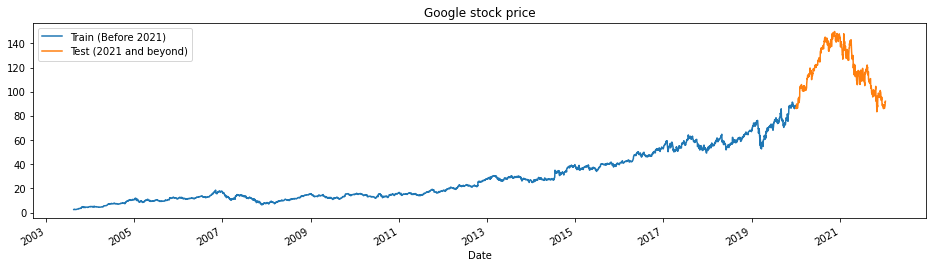

In [10]:
def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "Close"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "Close"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Google stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [11]:
## Train and Test data split function
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "Close"].values
    test = dataset.loc[f"{tend+1}":, "Close"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [12]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [13]:
training_set[1:61], training_set[61]

(array([[2.71045995],
        [2.73773789],
        [2.62437391],
        [2.65265298],
        [2.70044994],
        [2.65640593],
        [2.55280304],
        [2.56181192],
        [2.50875902],
        [2.54029012],
        [2.50275302],
        [2.54204202],
        [2.56006002],
        [2.56030989],
        [2.63588595],
        [2.69019008],
        [2.79004002],
        [2.80280304],
        [2.85210204],
        [2.94019008],
        [2.98698711],
        [2.9489491 ],
        [2.96246195],
        [3.02352405],
        [2.99874902],
        [2.95945907],
        [3.17467499],
        [3.28028011],
        [3.24324298],
        [3.31781793],
        [3.37987995],
        [3.462713  ],
        [3.43042994],
        [3.47472501],
        [3.446697  ],
        [3.38488507],
        [3.43843794],
        [3.52602601],
        [3.55355406],
        [3.60635591],
        [3.73273301],
        [3.70220208],
        [3.51576591],
        [3.7382381 ],
        [4.31506491],
        [4

In [14]:
dataset.shape

(4634, 6)

In [15]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 40

# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [16]:
X_train.shape

(4082, 40, 1)

In [17]:
## Printing the first record after sequencing
print(X_train[0])

## Number of input values in the each record
print("\n\nNumber of values in each record (features) :", len(X_train[0]))

[[9.30508387e-05]
 [2.34047199e-03]
 [2.64784388e-03]
 [1.37044198e-03]
 [1.68909463e-03]
 [2.22767781e-03]
 [1.73138338e-03]
 [5.63970935e-04]
 [6.65484360e-04]
 [6.76765122e-05]
 [4.22973500e-04]
 [0.00000000e+00]
 [4.42714162e-04]
 [6.45743698e-04]
 [6.48559187e-04]
 [1.50016134e-03]
 [2.11206813e-03]
 [3.23719182e-03]
 [3.38100743e-03]
 [3.93651578e-03]
 [4.92910463e-03]
 [5.45642048e-03]
 [5.02780256e-03]
 [5.18006733e-03]
 [5.86812396e-03]
 [5.58895532e-03]
 [5.14623042e-03]
 [7.57131484e-03]
 [8.76128881e-03]
 [8.34394898e-03]
 [9.18427037e-03]
 [9.88359433e-03]
 [1.08169693e-02]
 [1.04531989e-02]
 [1.09523223e-02]
 [1.06364986e-02]
 [9.93999277e-03]
 [1.05434343e-02]
 [1.15303895e-02]
 [1.18405795e-02]]


Number of values in each record (features) : 40


In [18]:
X_train.shape

(4082, 40, 1)

In [19]:
# Reshaping X_train for model
features=1
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [20]:
# The LSTM architecture
model_lstm = Sequential()

## RNN Layer
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))

## Output Layer
model_lstm.add(Dense(units=1))

# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [21]:
## Fitting the model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
128/128 [==============================] - 18s 109ms/step - loss: 0.0023
Epoch 2/50
128/128 [==============================] - 9s 69ms/step - loss: 6.9384e-04
Epoch 3/50
128/128 [==============================] - 10s 79ms/step - loss: 5.0254e-04
Epoch 4/50
128/128 [==============================] - 7s 55ms/step - loss: 3.9558e-04
Epoch 5/50
128/128 [==============================] - 7s 55ms/step - loss: 3.2347e-04
Epoch 6/50
128/128 [==============================] - 7s 54ms/step - loss: 3.1316e-04
Epoch 7/50
128/128 [==============================] - 7s 58ms/step - loss: 2.7732e-04
Epoch 8/50
128/128 [==============================] - 8s 62ms/step - loss: 2.4696e-04
Epoch 9/50
128/128 [==============================] - 8s 66ms/step - loss: 2.3380e-04
Epoch 10/50
128/128 [==============================] - 7s 55ms/step - loss: 2.1730e-04
Epoch 11/50
128/128 [==============================] - 7s 54ms/step - loss: 2.0930e-04
Epoch 12/50
128/128 [==============================] 

In [22]:
dataset_total = dataset.loc[:,"Close"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
print(type(input))


<class 'method'>


In [23]:
inputs = inputs.reshape(-1, 1)

#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)

# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

#prediction
predicted_stock_price = model_lstm.predict(X_test)

#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 [==============================] - 1s 20ms/step


In [24]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Google Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("google Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

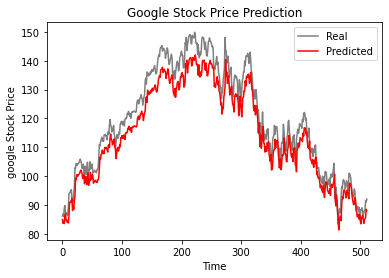

In [25]:
plot_predictions(test_set,predicted_stock_price)

In [26]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 5.66.


In [27]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
128/128 [==============================] - 8s 44ms/step - loss: 0.0020
Epoch 2/50
128/128 [==============================] - 5s 42ms/step - loss: 4.7151e-04
Epoch 3/50
128/128 [==============================] - 7s 54ms/step - loss: 3.3761e-04
Epoch 4/50
128/128 [==============================] - 5s 42ms/step - loss: 3.0696e-04
Epoch 5/50
128/128 [==============================] - 5s 42ms/step - loss: 2.6082e-04
Epoch 6/50
128/128 [==============================] - 5s 41ms/step - loss: 2.3662e-04
Epoch 7/50
128/128 [==============================] - 5s 42ms/step - loss: 2.1527e-04
Epoch 8/50
128/128 [==============================] - 5s 41ms/step - loss: 1.9288e-04
Epoch 9/50
128/128 [==============================] - 5s 42ms/step - loss: 1.8307e-04
Epoch 10/50
128/128 [==============================] - 5s 42ms/step - loss: 1.7877e-04
Epoch 11/50
128/128 [==============================] - 5s 41ms/step - loss: 1.7306e-04
Epoch 12/50
128/128 [==============================] - 5

16/16 [==============================] - 1s 12ms/step


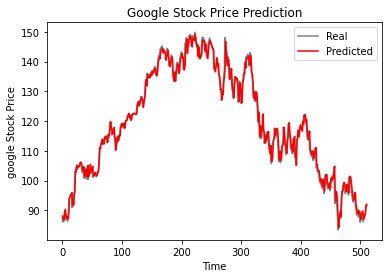

In [29]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [30]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 2.36.


In [31]:
model_bid = Sequential()
model_bid.add(Bidirectional(LSTM(units=100, activation="tanh", input_shape=(n_steps, features))))
model_bid.add(Dense(units=1))
# Compiling the RNN
model_bid.compile(optimizer="RMSprop", loss="mse")

In [32]:
model_bid.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
128/128 [==============================] - 11s 49ms/step - loss: 0.0029
Epoch 2/25
128/128 [==============================] - 6s 47ms/step - loss: 6.7468e-04
Epoch 3/25
128/128 [==============================] - 6s 48ms/step - loss: 4.9198e-04
Epoch 4/25
128/128 [==============================] - 6s 47ms/step - loss: 3.8964e-04
Epoch 5/25
128/128 [==============================] - 6s 48ms/step - loss: 3.4143e-04
Epoch 6/25
128/128 [==============================] - 6s 47ms/step - loss: 3.0530e-04
Epoch 7/25
128/128 [==============================] - 6s 48ms/step - loss: 2.6742e-04
Epoch 8/25
128/128 [==============================] - 6s 48ms/step - loss: 2.6520e-04
Epoch 9/25
128/128 [==============================] - 6s 47ms/step - loss: 2.4386e-04
Epoch 10/25
128/128 [==============================] - 6s 47ms/step - loss: 2.1909e-04
Epoch 11/25
128/128 [==============================] - 6s 48ms/step - loss: 2.1637e-04
Epoch 12/25
128/128 [==============================] - 

16/16 [==============================] - 1s 16ms/step


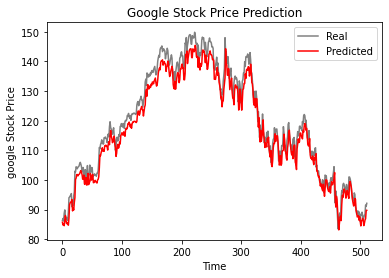

In [33]:
BID_predicted_stock_price = model_bid.predict(X_test)
BID_predicted_stock_price = sc.inverse_transform(BID_predicted_stock_price)
plot_predictions(test_set, BID_predicted_stock_price)

In [34]:
return_rmse(test_set,BID_predicted_stock_price)

The root mean squared error is 3.67.
